# Simulate the ground state of a Hydrogen molecule using Variational Quantum Eigensolver (VQE) on the IonQ simulator

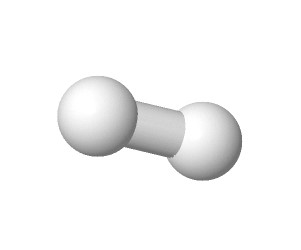

In this notebook, you'll learn how to run VQE for a $H_{2}$ molecule on the IonQ simulator using Qiskit on an Azure Quantum backend.

VQE is a variational algorithm for quantum chemistry that uses an optimization loop to minimize a cost function. The cost function is an energy evaluation $H|\psi> = E|\psi>$ where $|\psi>$ is a parametric trial state that estimates the ground state of the molecule. For each evaluation, we modify the trial state until the energy reaches a minimum.

For more information about running VQE using Qiskit, see: [Qiskit Textbook - VQE Molecules](https://qiskit.org/textbook/ch-applications/vqe-molecules.html#implementationnoisy).

To read more about the optimization method used in this example, see [Wikipedia - SPSA](https://en.wikipedia.org/wiki/Simultaneous_perturbation_stochastic_approximation).

Before geting started, you need to install and import some packages.

In [1]:
!pip install qiskit-aer

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ, BasicAer, Aer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.circuit.library import EfficientSU2
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

First, prepare the qubit operators to get the one-body and two-body integrals that encode the Hydrogen molecule and map them onto qubits using Quantum gates.

You'll use [PySCF](https://github.com/pyscf/pyscf) to generate the molecule, and [Qiskit Chemistry](https://quantum-computing.ibm.com/lab/docs/iql/chemistry) to encode it into Fermionic operators.

In [3]:
# Create a PySCF driver an generate the molecule
driver = PySCFDriver(atom='H .0 .0 -0.3625; H .0 .0 0.3625', unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()
# Get the total number of particles in the molecule
num_particles = molecule.num_alpha + molecule.num_beta
# Convert one-body and two-body integrals into fermionic operators
qubit_op = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals).mapping(map_type='parity')
qubit_op = Z2Symmetries.two_qubit_reduction(qubit_op, num_particles)

## 1. Simulate locally

Here, you will simulate the program locally using the Aer simulator. You can create a `QuantumInstance` with a noise model, generated using a mock device `FakeVigo` with noise characteristics.

In [4]:
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel

backend = AerSimulator()
device_backend = FakeVigo()
device = QasmSimulator.from_backend(device_backend)

Then, run the simulation using the VQE class.

### Simulate locally with noise and error mitigation

In [5]:
# Create the noise characteristics and other parameters that describe the device
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

# Create the quantum instance to conncet to the backend
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=8192, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

# Calculate the exact solution using numpy
exact_solution = NumPyEigensolver(qubit_op).run()
print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)

# Create an optimizer (using SPSA)
optimizer = SPSA(maxiter=100)

# Create the variational form
var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")

# Create a VQE object that runs VQE using the above created qubit operations, variational form and optimizer
vqe = VQE(qubit_op, var_form, optimizer=optimizer)

# Run the full VQE program
ret = vqe.run(quantum_instance)

# Get and print the result
vqe_result = np.real(ret['eigenvalue'] + molecule.nuclear_repulsion_energy)
print("VQE Result on noisy simulator:", vqe_result)

Exact Result: [-1.13722138]
VQE Result on noisy simulator: -1.0958617195350147


The parameters found by the optimization loop:

In [6]:
p0 = ret.optimal_point
p0

array([ 0.75759584,  2.68404484,  1.15902937, -1.71621361, -2.46762699,
       -1.09722578,  0.07579694,  0.88938069,  1.2065511 ,  0.15724757,
        2.30434445,  0.37531045,  1.74550594,  1.64111366, -2.00842078,
       -1.14800172])

The energy was evaluated a total of `ret.cost_function_evals` times until the minimum was found.

In [7]:
ret.cost_function_evals

241

### Circuit visualization

Each energy evaluation consists of two circuits that are run. You can visualize these circuits with Qiskit using the `vqe` instance.

In [8]:
# The VQE class generates extra unused wires.
# This function is to remove idle wires to make the visualization more readable.
# See: https://quantumcomputing.stackexchange.com/questions/25672/remove-inactive-qubits-from-qiskit-circuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict

def remove_idle_qwires(circ):
    dag = circuit_to_dag(circ)

    idle_wires = list(dag.idle_wires())
    for w in idle_wires:
        dag._remove_idle_wire(w)
        dag.qubits.remove(w)

    dag.qregs = OrderedDict()

    return dag_to_circuit(dag)

circs = vqe._circuit_sampler._transpiled_circ_cache
circs = [remove_idle_qwires(circ) for circ in circs]
circ = circs[0]

In [9]:
circ.draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
   0: ┤ Ry(θ[0]) ├┤ Rz(θ[2]) ├──■──┤ Ry(θ[4]) ├┤ Rz(θ[6]) ├──■──┤ Ry(θ[8]) ├»
      ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
   1: ┤ Ry(θ[1]) ├┤ Rz(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├┤ Rz(θ[7]) ├┤ X ├┤ Ry(θ[9]) ├»
      └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
c0: 2/══════════════════════════════════════════════════════════════════════»
                                                                            »
«      ┌───────────┐     ┌───────────┐┌───────────┐┌───┐┌─┐   
«   0: ┤ Rz(θ[10]) ├──■──┤ Ry(θ[12]) ├┤ Rz(θ[14]) ├┤ H ├┤M├───
«      ├───────────┤┌─┴─┐├───────────┤├───────────┤├───┤└╥┘┌─┐
«   1: ┤ Rz(θ[11]) ├┤ X ├┤ Ry(θ[13]) ├┤ Rz(θ[15]) ├┤ H ├─╫─┤M├
«      └───────────┘└───┘└───────────┘└───────────┘└───┘ ║ └╥┘
«c0: 2/══════════════════════════════════════════════════╩══╩═
«                                                        0  1

This shows the parametric trial state that is prepared and evaluated as part of VQE. The parameters, $\theta[n]$, are assigned a value for each iteration.

In [10]:
circ.assign_parameters(ret.optimal_parameters).draw()

┌───────────────────────┐ ┌──────────────────────┐     »
   0: ┤ Ry(0.757595837955051) ├─┤ Rz(1.20655109607776) ├──■──»
      ├───────────────────────┤┌┴──────────────────────┤┌─┴─┐»
   1: ┤ Ry(0.889380691478043) ├┤ Rz(0.157247566275449) ├┤ X ├»
      └───────────────────────┘└───────────────────────┘└───┘»
c0: 2/═══════════════════════════════════════════════════════»
                                                             »
«       ┌──────────────────────┐┌──────────────────────┐     »
«   0: ─┤ Ry(2.30434445294033) ├┤ Rz(1.74550593976197) ├──■──»
«      ┌┴──────────────────────┤├──────────────────────┤┌─┴─┐»
«   1: ┤ Ry(0.375310451918903) ├┤ Rz(1.64111365590957) ├┤ X ├»
«      └───────────────────────┘└──────────────────────┘└───┘»
«c0: 2/══════════════════════════════════════════════════════»
«                                                            »
«      ┌───────────────────────┐┌──────────────────────┐     »
«   0: ┤ Ry(-2.00842078118953) ├┤ Rz(2.68404483537343) ├──■──»
«      ├───────────────────────┤├──────────────────────┤┌─┴─┐»
«   1: ┤ Ry(-1.14800172093999) ├┤ Rz(1.15902936540107) ├┤ X ├»
«      └───────────────────────┘└──────────────────────┘└───┘»
«c0: 2/══════════════════════════════════════════════════════»
«                                                            »
«      ┌───────────────────────┐┌───────────────────────┐ ┌───┐┌─┐   
«   0: ┤ Ry(-1.71621360731209) ├┤ Rz(-1.09722578377892) ├─┤ H ├┤M├───
«      ├───────────────────────┤├───────────────────────┴┐├───┤└╥┘┌─┐
«   1: ┤ Ry(-2.46762699108509) ├┤ Rz(0.0757969361872165) ├┤ H ├─╫─┤M├
«      └───────────────────────┘└────────────────────────┘└───┘ ║ └╥┘
«c0: 2/═════════════════════════════════════════════════════════╩══╩═
«                                                               0  1

## 2. Run on IonQ simulator via Azure Quantum Workspace

Now, you can connect to the Azure Quantum Workspace and run VQE on the hardware backends.

In [11]:
# Connect to the Azure Quantum Workspace via a Qiskit provider
from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider(
    resource_id = "",
    location = ""
)

# Create IonQ simulator backend
ionq_simulator_backend = provider.get_backend("ionq.simulator")

### Run one iteration on IonQ simulator via Azure Quantum

It can take a long time to run a full VQE program on hardware, because each iteration puts a circuit in the queue. To save time and cost, let's run only the last (optimal) iteration using the parameters we found with the Aer simulator.

In [12]:
# This is a bug that will be addressed in this PR: https://github.com/microsoft/qdk-python/pull/301
ionq_simulator_backend.configuration().max_shots = None

In [13]:
# Create Quantum Instance
quantum_instance = QuantumInstance(backend=ionq_simulator_backend,
                                   shots=8192)
# Unset qjob config to avoid errors when running job.result()
quantum_instance._qjob_config = {}

In [14]:
# Create optimizer with only one iteration
optimizer = SPSA(maxiter=1)
# Create the variational form of the ansatz
var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
# Create a VQE object that runs the algorithm
vqe = VQE(qubit_op, var_form, optimizer=optimizer)
# Set the quantum instance to be able to run only the last iteration
vqe.quantum_instance = quantum_instance

The below cell will evaluate the energy at `p0` using the IonQ simulator.

You have to add the molecular nuclear repulsion energy to the final result to get the ground state of the molecule.

In [15]:
vqe._energy_evaluation(parameters=p0) + molecule.nuclear_repulsion_energy

......

-1.1328210248074357